# Functionality

Simulated data for validation the usage of ciCOH

* using Samplings from normal distributions for no connections

* using sinusoidal signals for connections

* using a linear mix equation for volume conduction

## Import Packages

In [1]:
import os, sys
import scipy.io as sio
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import random
import pandas as pd
%matplotlib inline

In [2]:
# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)

# import_nbmodule used for import package in .ipynb
import import_nbmodule

# import util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

# import ciCoherence_overtime in connAnalyTool/synchronization_indices.ipynb
from connAnalyTool.synchronization_indices import ciCoherence_acrosstrials
from connAnalyTool.synchronization_indices import ciCoherence_overtime

importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb
importing Jupyter notebook from /Users/linglingyang/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/synchronization_indices.ipynb


## Preparation

### exp subfolders & code_corresfolder

In [3]:
_, _, pipelinefolder, _= exp_subfolders()

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

# corresfolder
corresfolder, correparentfolder = code_corresfolder(os.getcwd(), nb_name)

### Global parameters

In [6]:
ntemp, ntrials = 500, 239

# repeat ntimes
ntimes = 1000

### Input setup

### Save setup

In [7]:
savefolder = corresfolder

##  Simulated Data with Normal Distribution (no connection)

In [8]:
mu, sigma = 0, 1

### A trial Example

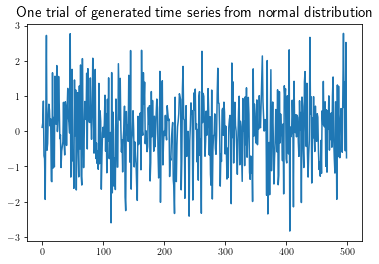

In [9]:
import matplotlib.pyplot as plt
from numpy.random import normal

# generated s signals: 
sig = normal(mu, sigma, (ntemp,))
    
# plot
plt.rc('text', usetex=True)

plt.plot(sig)

title = "One trial of generated time series from normal distribution"
plt.title(title, size=15)

#plt.show()
plt.savefig(os.path.join(savefolder,  "normal_oneTrialExample.png"))
             
sig_normal = sig

### generate time series 

In [10]:
sigs1_normal, sigs2_normal = normal(mu, sigma, (ntimes, ntrials, ntemp)), normal(mu, sigma, (ntimes, ntrials, ntemp)) 

### Calc ciCOH

In [11]:
import numpy as np
from numpy.random import normal

sigs1, sigs2 = sigs1_normal, sigs2_normal

ciCOHs = []
for timei in range(ntimes):

    sig1, sig2 = sigs1[timei, :, :], sigs2[timei, :, :]
    
    # calculate ciCOH
    ciCOH = np.mean(ciCoherence_acrosstrials(sig1, sig2))
    ciCOHs.append(ciCOH)
    
    del ciCOH, sig1, sig2 
    
ciCOHs_normal = ciCOHs
del ciCOHs

### plot ciCOH

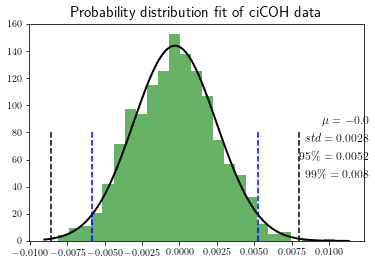

In [12]:
from scipy.stats import norm
import matplotlib.pyplot as plt

ciCOHs = ciCOHs_normal

plt.rc('text', usetex=True)

# Fit a normal distribution to the data:
mu, std = norm.fit(ciCOHs)

# Plot the histogram.
plt.hist(ciCOHs, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)


# plot the 2*std lines
plt.plot([mu + 2 * std, mu + 2 * std], np.array(plt.ylim())/2, 'b--', 
         [mu - 2 * std, mu - 2 * std], np.array(plt.ylim())/2, 'b--')

# plot the 3*std lines
plt.plot([mu + 3 * std, mu + 3 * std], np.array(plt.ylim())/2, 'k--', 
         [mu - 3 * std, mu - 3 * std], np.array(plt.ylim())/2, 'k--')


eq1 = r"\begin{eqnarray*}" + \
      r"\mu = " + str(np.around(mu, decimals=2)) + "\\"\
      r"\std = " + str(np.around(std, decimals=4)) + "\\"\
      r"\95 \%= " + str(np.around(mu + 2*std, decimals=4)) + "\\"\
      r"\99 \%= " + str(np.around(mu + 3*std, decimals=4)) +\
      r"\end{eqnarray*}"

plt.text(0.008, 90, eq1, {'fontsize': 12}, va="top", ha="left")

title = "Probability distribution fit of ciCOH data"
plt.title(title, size=15)

#plt.show()
plt.savefig(os.path.join(savefolder,  "normal_ciCOHpdf.png"))

del ciCOHs

## Simulated Data with Sinusoidal Distribution (with Connection)

In [13]:
Desired_SNR_dB = 20

f = 30

t = np.linspace(0, 0.5, ntemp)

### A trial example

In [14]:
import numpy as np

def GaussianNoise_SNR(signal, Desired_SNR_dB):
    """
        add desired SNR (dB) gaussian noise to signal
        SNR(dB) = 10 * log10(power_signal/power_noise)

        @ parameter:
            signal: (n_times,)
            Desired_SNR_dB: desired SNR in dB
        
        @ return 
            signal_noisy: (n_times,)
    """
    
    n_times = signal.shape[0]
    noise = np.random.normal(loc=0.0, scale=1.0, size=(n_times,))

    power_signal = np.dot(abs(signal), abs(signal))/n_times
    power_noise = np.dot(abs(noise), abs(noise))/n_times 

    k = (power_signal * pow(10,(-Desired_SNR_dB/10)))/power_noise # scale factor
    noise_new = np.sqrt(k) * noise

    signal_noisy = signal + noise_new

    return signal_noisy

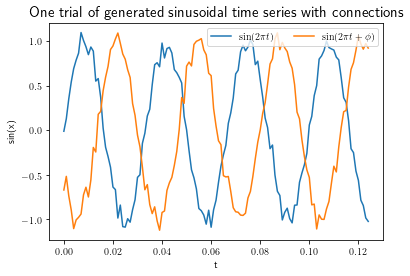

In [15]:
import matplotlib.pylab as plt
from numpy.random import normal

phi = normal(loc=np.pi, scale=1.0)


s1 = np.sin(2 * np.pi * f* t)
s2 = np.sin(2 * np.pi * f * t + phi)


# add normal distribution noise
s1 = GaussianNoise_SNR(s1, Desired_SNR_dB = Desired_SNR_dB)
s2 = GaussianNoise_SNR(s2, Desired_SNR_dB = Desired_SNR_dB)

npoints = 125
plt.plot(t[0:npoints], s1[0:npoints], t[0:npoints], s2[0:npoints])


plt.xlabel('t')
plt.ylabel('sin(x)')
plt.axis('tight')


# legend
eq1 = r"\begin{eqnarray*}" + r"\sin(2\pi t)" +  r"\end{eqnarray*}"
eq2 = r"\begin{eqnarray*}" + r"\sin(2\pi t + \phi)" +  r"\end{eqnarray*}"
plt.legend((eq1, eq2), ncol = 2, loc = 1)


title = "One trial of generated sinusoidal time series with connections"
plt.title(title, size=15)

#plt.show()
plt.savefig(os.path.join(savefolder,  "sin_TimeSeries_Exampe.png"))

s1_1trial_sin, s2_1trial_sin = s1, s2

### generate time series

In [16]:
# generated s1, s2 signals: ntimes * ntrials * ntemp
sigs1, sigs2 = np.empty(shape=(0, ntrials, ntemp)), np.empty(shape=(0, ntrials, ntemp))
for timei in range(ntimes):
    
    if timei % 5 ==0:
        print("timei = " + str(timei) + "/" + str(ntimes))
    
    # generated s1, s2 signals: ntrials * ntemp
    sig1, sig2 = np.empty(shape=[0,ntemp]), np.empty(shape=[0,ntemp])
    phi = normal(loc=np.pi, scale=1.0)
    for triali in range(ntrials):
        
        s1 = np.sin(2 * np.pi * f * t)
        s2 = np.sin(2 * np.pi * f * t + phi)

        # add normal distribution noise
        s1 = GaussianNoise_SNR(s1, Desired_SNR_dB = Desired_SNR_dB)
        s2 = GaussianNoise_SNR(s2, Desired_SNR_dB = Desired_SNR_dB)

        # append the time serie of the new trial
        sig1 = np.append(sig1, np.expand_dims(s1, axis = 0), axis=0)
        sig2 = np.append(sig2, np.expand_dims(s2, axis = 0), axis=0)
        
        del s1, s2
        
    # append the time serie of the new trial
    sigs1 = np.append(sigs1, np.expand_dims(sig1, axis = 0), axis=0)
    sigs2 = np.append(sigs2, np.expand_dims(sig2, axis = 0), axis=0)
    
    del sig1, sig2
    
sigs1_sin, sigs2_sin = sigs1, sigs2

del sigs1, sigs2

timei = 0
timei = 1
timei = 2
timei = 3
timei = 4
timei = 5
timei = 6
timei = 7
timei = 8
timei = 9
timei = 10
timei = 11
timei = 12
timei = 13
timei = 14
timei = 15
timei = 16
timei = 17
timei = 18
timei = 19
timei = 20
timei = 21
timei = 22
timei = 23
timei = 24
timei = 25
timei = 26
timei = 27
timei = 28
timei = 29
timei = 30
timei = 31
timei = 32
timei = 33
timei = 34
timei = 35
timei = 36
timei = 37
timei = 38
timei = 39
timei = 40
timei = 41
timei = 42
timei = 43
timei = 44
timei = 45
timei = 46
timei = 47
timei = 48
timei = 49
timei = 50
timei = 51
timei = 52
timei = 53
timei = 54
timei = 55
timei = 56
timei = 57
timei = 58
timei = 59
timei = 60
timei = 61
timei = 62
timei = 63
timei = 64
timei = 65
timei = 66
timei = 67
timei = 68
timei = 69
timei = 70
timei = 71
timei = 72
timei = 73
timei = 74
timei = 75
timei = 76
timei = 77
timei = 78
timei = 79
timei = 80
timei = 81
timei = 82
timei = 83
timei = 84
timei = 85
timei = 86
timei = 87
timei = 88
timei = 89
timei = 90
timei = 9

timei = 692
timei = 693
timei = 694
timei = 695
timei = 696
timei = 697
timei = 698
timei = 699
timei = 700
timei = 701
timei = 702
timei = 703
timei = 704
timei = 705
timei = 706
timei = 707
timei = 708
timei = 709
timei = 710
timei = 711
timei = 712
timei = 713
timei = 714
timei = 715
timei = 716
timei = 717
timei = 718
timei = 719
timei = 720
timei = 721
timei = 722
timei = 723
timei = 724
timei = 725
timei = 726
timei = 727
timei = 728
timei = 729
timei = 730
timei = 731
timei = 732
timei = 733
timei = 734
timei = 735
timei = 736
timei = 737
timei = 738
timei = 739
timei = 740
timei = 741
timei = 742
timei = 743
timei = 744
timei = 745
timei = 746
timei = 747
timei = 748
timei = 749
timei = 750
timei = 751
timei = 752
timei = 753
timei = 754
timei = 755
timei = 756
timei = 757
timei = 758
timei = 759
timei = 760
timei = 761
timei = 762
timei = 763
timei = 764
timei = 765
timei = 766
timei = 767
timei = 768
timei = 769
timei = 770
timei = 771
timei = 772
timei = 773
timei = 774
time

### Calc ciCOH 

In [17]:
import matplotlib.pylab as plt
from numpy.random import normal

sigs1, sigs2 = sigs1_sin, sigs2_sin

ciCOHs = []
for timei in range(ntimes):
    
    sig1, sig2 = sigs1[timei, :, :], sigs2[timei, :, :]
        
    # calculate ciCOH
    ciCOH = np.mean(ciCoherence_acrosstrials(sig1, sig2))
    ciCOHs.append(ciCOH)
        
    
    del sig1, sig2, ciCOH
    
ciCOHs_sin = ciCOHs
del ciCOHs, sigs1, sigs2

### plot ciCOH

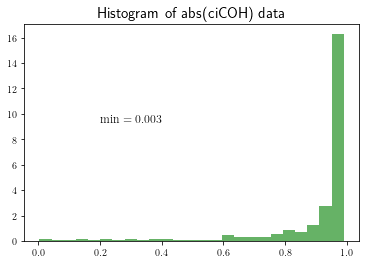

In [18]:
from scipy.stats import norm
import matplotlib.pyplot as plt


ciCOHs = ciCOHs_sin

ciCOHs = abs(np.array(ciCOHs))

plt.rc('text', usetex=True)

# Fit a normal distribution to the data:
mu, std = norm.fit(abs(ciCOHs))

# Plot the histogram.
plt.hist(ciCOHs, bins=25, density=True, alpha=0.6, color='g')


eq1 = r"\begin{eqnarray*}" + \
      r"\min = " + str(np.around(np.min(ciCOHs), decimals=3)) + \
      r"\end{eqnarray*}"

plt.text(0.2, 10, eq1, {'fontsize': 12}, va="top", ha="left")

title = "Histogram of abs(ciCOH) data"
plt.title(title, size=15)

#plt.show()
plt.savefig(os.path.join(savefolder,  "sin_ciCOHHist.png"))

del ciCOHs

## Volume Conduction

In [19]:
alpha = 0.5

In [20]:
### no connection ####

x_noConn, y_noConn = sigs1_normal, sigs2_normal
ciCOH_ori, ciCOH_new = [], []
for timei in range(x_noConn.shape[0]):

    x, y = x_noConn[timei, :, :], y_noConn[timei, :, :] 
    x_new, y_new = x + alpha * y,  y + alpha * x

    # calculate ciCOH
    ciCOH_ori = np.append(ciCOH_ori, np.mean(ciCoherence_acrosstrials(x, y)))
    ciCOH_new = np.append(ciCOH_new, np.mean(ciCoherence_acrosstrials(x_new, y_new)))

    del x,  y, x_new, y_new
    
ciCOH_noConn_ori, ciCOH_noConn_new = ciCOH_ori, ciCOH_new
del ciCOH_ori, ciCOH_new

In [21]:
### connection ####

x_Conn, y_Conn = sigs1_sin, sigs2_sin
ciCOH_ori, ciCOH_new = [], []
for timei in range(x_Conn.shape[0]):

    x, y = x_Conn[timei, :, :], y_Conn[timei, :, :] 
    x_new, y_new = x + alpha * y,  y + alpha * x

    # calculate ciCOH
    ciCOH_ori = np.append(ciCOH_ori, np.mean(ciCoherence_acrosstrials(x, y)))
    ciCOH_new = np.append(ciCOH_new, np.mean(ciCoherence_acrosstrials(x_new, y_new)))

    del x,  y, x_new, y_new
    
ciCOH_Conn_ori, ciCOH_Conn_new = ciCOH_ori, ciCOH_new
del ciCOH_ori, ciCOH_new

### plot

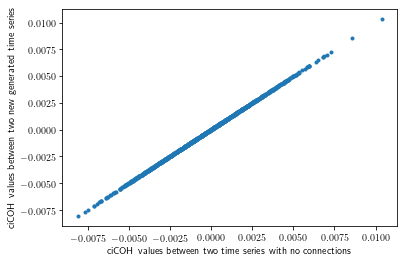

In [22]:
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.plot(ciCOH_noConn_ori, ciCOH_noConn_new, '.')
plt.xlabel('ciCOH values between two time series with no connections')
plt.ylabel('ciCOH values between two new generated time series')

plt.savefig(os.path.join(savefolder,  "volume_noconn.png"))

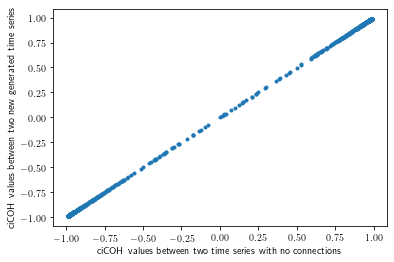

In [23]:
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.plot(ciCOH_Conn_ori, ciCOH_Conn_new, '.')
plt.xlabel('ciCOH values between two time series with no connections')
plt.ylabel('ciCOH values between two new generated time series')

plt.savefig(os.path.join(savefolder,  "volume_conn.png"))